In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

In [2]:
import warnings
warnings.filterwarnings("ignore")
import scanpy.api as sc
from scanpy.neighbors import Neighbors
import scanorama

# Evaluating Alignment Score For Batch Correction With Gene-Specific Batch Effect

This notebook evaluates an "alignment score" to quantify the effects of batch correction. This notebook uses this metric to measure the performance of the Scanorama algorithm on two batches of Olivier's CAOV3 data with one batch receiving an addition of gene-specific batch effect.

# Load Data

In [3]:
B1 = sc.read_10x_mtx("./data/Harismendy_data/170206/CAOV3", var_names="gene_symbols")
B2 = sc.read_10x_mtx("./data/Harismendy_data/170315/CAOV3", var_names="gene_symbols")

## Downsample For Performance

In [4]:
def downsample_anndata(ad, n):
    rand_obs = np.random.choice(list(ad.obs.index), size=n, replace=False)
    return ad[rand_obs,:]

In [5]:
CAOV3_B1 = downsample_anndata(B1, 500)
CAOV3_B2 = downsample_anndata(B2, 500)

In [6]:
CAOV3_B1.shape

(500, 33694)

In [7]:
CAOV3_B2.shape

(500, 33694)

In [8]:
B1_ncells, B1_ngenes = CAOV3_B1.shape[0], CAOV3_B1.shape[1]
B2_ncells, B2_ngenes = CAOV3_B2.shape[0], CAOV3_B2.shape[1]

# Implement Alignment Score

In [9]:
INPUT_ANNS = [CAOV3_B1, CAOV3_B2]

In [10]:
min_cells = min(list(map(lambda x: x.n_obs, INPUT_ANNS)))
DS_ANNS = list(map(lambda x: downsample_anndata(x, min_cells), INPUT_ANNS))

## Merge Experiments

In [11]:
COMB_ANN = DS_ANNS[0].concatenate(DS_ANNS[1:], index_unique="_")
COMB_ANN.shape

(1000, 33694)

## Find Closest 1% Neighbors For All Cells

In [12]:
n_batch = len(INPUT_ANNS)

In [13]:
n_neighbors = max(int(0.01*min_cells), 10)
n_neighbors

10

In [14]:
sc.pp.neighbors(COMB_ANN, n_neighbors=22, knn=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.


## Calculate Alignment Score

In [15]:
rows, cols = COMB_ANN.uns['neighbors']['distances'].nonzero()

In [16]:
def get_batch(i, adata):
    """
    Returns the batch number of a cell at index i in adata
    """
    return int(adata.obs.index[i].split('_')[1])

In [17]:
neighbor_counts = {}  #{cell_id: #same_batch}

for x, y in zip(rows, cols):
    try:
        neighbor_counts[x]
    except KeyError:
        neighbor_counts[x] = 0
    cell_batch = get_batch(x, COMB_ANN)
    neigh_batch = get_batch(y, COMB_ANN)
    if cell_batch == neigh_batch:
        neighbor_counts[x] += 1

In [18]:
(np.mean(list(neighbor_counts.values()))/n_neighbors)*n_batch

2.2290000000000001

# Summary Implementation Function

This cell defines a single function to run the above analysis given a list of AnnData

In [19]:
def downsample_anndata(ad, n):
    rand_obs = np.random.choice(list(ad.obs.index), size=n, replace=False)
    return ad[rand_obs,:]

def get_batch(i, adata):
    """
    Returns the batch number of a cell at index i in adata
    """
    return int(adata.obs.index[i].split('_')[1])

def score_batch_corr(anns, n_neighbors):
    min_cells = min(list(map(lambda x: x.n_obs, anns)))
    ds_anns = list(map(lambda x: downsample_anndata(x, min_cells), anns))
    comb_ann = ds_anns[0].concatenate(ds_anns[1:], index_unique="_")
    sc.tl.pca(comb_ann)
    sc.pp.neighbors(comb_ann, n_neighbors=n_neighbors, knn=True)
    rows, cols = comb_ann.uns['neighbors']['distances'].nonzero()
    neighbor_counts = {}  #{cell_id: #same_batch}
    for x, y in zip(rows, cols):
        try:
            neighbor_counts[x]
        except KeyError:
            neighbor_counts[x] = 0
        cell_batch = get_batch(x, comb_ann)
        neigh_batch = get_batch(y, comb_ann)
        if cell_batch != neigh_batch:
            neighbor_counts[x] += 1
    sc.pl.pca(comb_ann, color='batch', show=True, save=False)
    return (np.mean(list(neighbor_counts.values()))/n_neighbors)*len(anns)

In [20]:
N_NEIGHBORS = int(0.01*CAOV3_B1.shape[0])
N_NEIGHBORS = 10

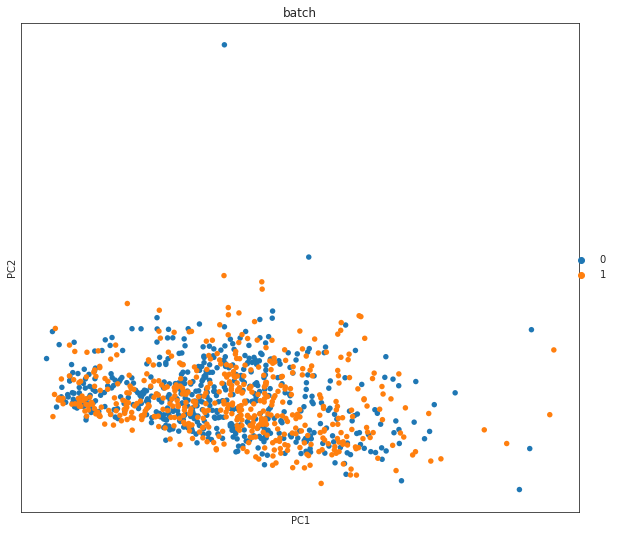

0.8256

In [21]:
score_batch_corr([CAOV3_B1, CAOV3_B2], N_NEIGHBORS)

# Add gene-specific batch effect to the second batch

In [22]:
# Generate random normal nums for each gene
normal_nums = np.random.normal(loc = 50, scale = 100, size = B2_ngenes)

# Return the indices of the elements that are non-zero.
# basically you look at rows, cols at the same time to find the location of the nonzero coordinates
rows, cols = CAOV3_B2.X.nonzero()
count = 0

for x, y in zip(rows, cols):
    added_val = normal_nums[y]
    CAOV3_B2.X[x, y] += added_val
    count += 1
    if count%100000 == 0:
        print(float(count)/len(rows)*100)  # progress tracking

6.8915090406261355
13.783018081252271
20.674527121878405
27.566036162504542
34.45754520313067
41.34905424375681
48.240563284382944
55.132072325009084
62.023581365635216
68.91509040626134
75.80659944688747
82.69810848751362
89.58961752813975
96.48112656876589


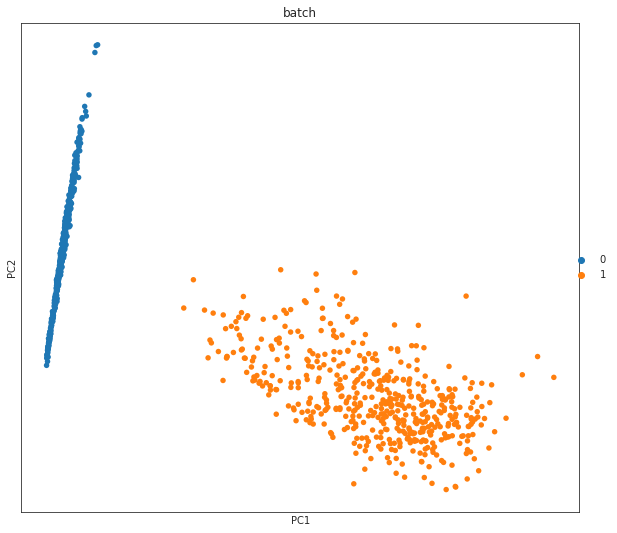

0.0

In [23]:
score_batch_corr([CAOV3_B1, CAOV3_B2], N_NEIGHBORS)

# Correct Data With Scanorama

Found 33694 genes among all datasets
[[ 0.     0.172]
 [ 0.     0.   ]]
Processing datasets (0, 1)


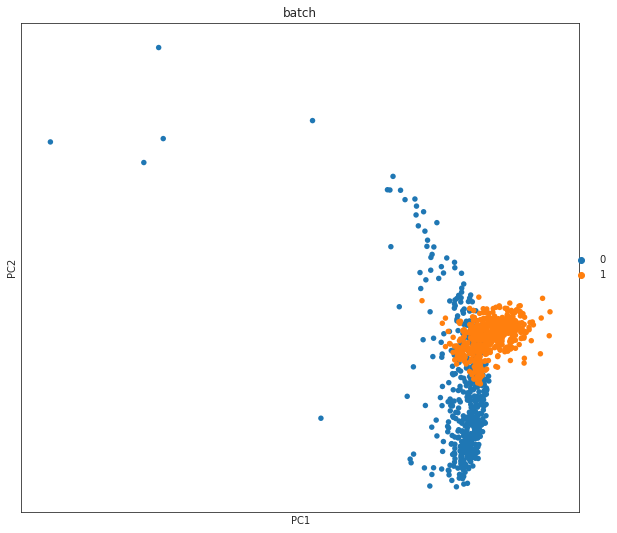

0.086599999999999996

In [24]:
CAOV3_B1, CAOV3_B2 = scanorama.correct_scanpy([CAOV3_B1, CAOV3_B2])
score_batch_corr([CAOV3_B1, CAOV3_B2], N_NEIGHBORS)